Нейросеть U-net может помочь сегментировать и распознавать объекты на изображениях с высокой точностью, что может быть полезно в медицинской диагностике, автоматическом распознавании образов и в других областях. Главная проблема, с которой стоялкнулся при выполнении работы, это очень мало общедоступных датасетов. 
Для улучшения точности U-net можно использовать следующие методы:

1. Увеличение объема данных для обучения: чем больше разнообразных данных, тем лучше нейросеть сможет обучиться и зафиксировать паттерны объектов.

2. Тщательный подбор параметров обучения: оптимальный выбор learning rate, batch size, количество эпох и другие параметры могут значительно повлиять на точность модели.

3. Использование предобученных моделей: можно использовать предобученные модели, чтобы улучшить качество и скорость обучения U-net.

4. Применение аугментации данных: изменение яркости, повороты, отражения и другие техники аугментации могут улучшить обобщающую способность модели.

5. Регуляризация: добавление регуляризации (например, dropout) может помочь снизить переобучение модели и улучшить ее обобщающую способность.

В целом, для достижения высокой точности нейросети U-net важно провести тщательное исследование работы модели, тестирование различных параметров и методов улучшения обучения. 

### Выводы: ###
Для успешной работы и улучшения точности нейросети U-net необходимо глубокое понимание архитектуры модели, оптимизация параметров и постоянное итеративное улучшение процесса обучения. Правильный подход к обучению и анализ результатов помогут достигнуть высокой точности и эффективности работы модели.

In [84]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [85]:
w, h = 304,304
border = 5 

In [86]:
ids = next(os.walk("train/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  9


# **Определение тренировочного теста**

In [87]:
import glob
train = sorted(glob.glob("train/images/*"))
train_mask = sorted(glob.glob("train/masks/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 9
Total Mask Image : 9


In [88]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [89]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [90]:
np.save('train/XandY/X.npy', X)
np.save('train/XandY/y.npy', y)
print(X.shape, y.shape)
X = np.load('train/XandY/X.npy')
y = np.load('train/XandY/y.npy')
print(X.shape, y.shape)

(9, 304, 304, 3) (9, 304, 304, 1)
(9, 304, 304, 3) (9, 304, 304, 1)


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(8, 304, 304, 3) (8, 304, 304, 1) (1, 304, 304, 3) (1, 304, 304, 1)


46107

# **Визуализация изображения и его маски**

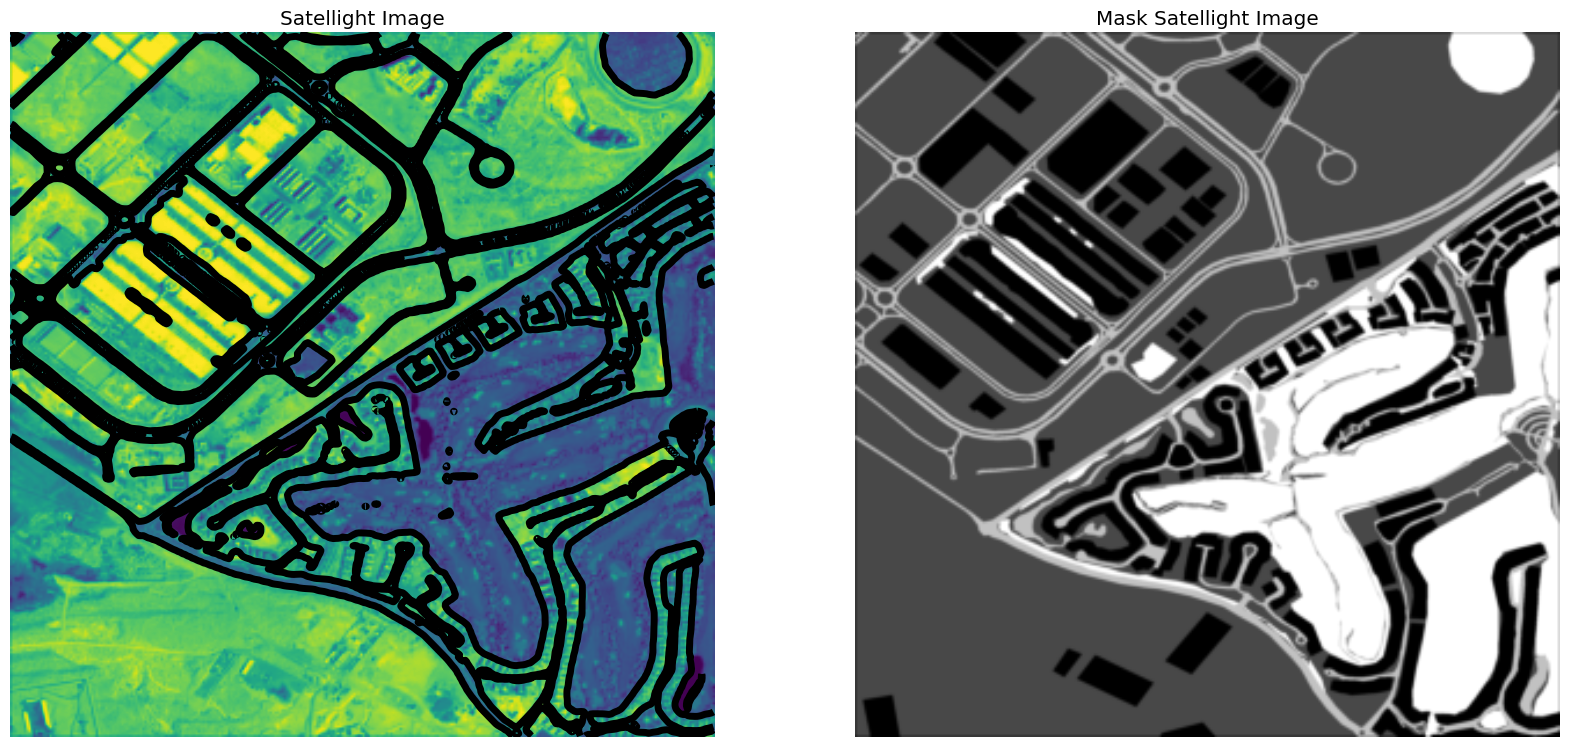

In [92]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

### Построение DenseUnet

In [93]:
def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1 = BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def DenseUNet(image_size=304):

    filters=16
    keep_prob=0.9
    block_size=7

    inputs = Input(shape=(image_size, image_size, 3))

    conv1 = Conv2D(filters * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(filters * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(filters * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(filters * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    convm = DenseBlock(filters * 8, pool3)

    deconv3 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(filters * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(filters * 4, uconv3)

    deconv2 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(filters * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(filters * 2, uconv2)

    deconv1 = Conv2DTranspose(filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(filters * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(filters * 1, uconv1)

    outputs = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [94]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = DenseUNet(image_size = 304)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [95]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 304, 304, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_8 (Conv2D)              (None, 304, 304, 4)  580         ['activation_7[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 304, 304, 4)  16         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 304, 304, 4)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 concatenate_3 (Concatenate)    (None, 304, 304, 32  0           ['activation[0][0]',             
                                )                                 'activation_2[0][0]',           
          

 activation_15 (Activation)     (None, 152, 152, 32  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 152, 152, 8)  2312        ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 152, 152, 8)  32         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 152, 152, 8)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 concatena

                                                                                                  
 activation_24 (Activation)     (None, 76, 76, 16)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 76, 76, 128)  0           ['max_pooling2d_1[0][0]',        
                                                                  'activation_18[0][0]',          
                                                                  'activation_20[0][0]',          
                                                                  'activation_22[0][0]',          
                                                                  'activation_24[0][0]']          
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 38, 38, 128)  0          ['concatenate_11[0][0]']         
          

                                                                  'activation_32[0][0]']          
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 76, 76, 64)  147520      ['concatenate_15[0][0]']         
 ose)                                                                                             
                                                                                                  
 concatenate_16 (Concatenate)   (None, 76, 76, 192)  0           ['conv2d_transpose[0][0]',       
                                                                  'concatenate_11[0][0]']         
                                                                                                  
 conv2d_33 (Conv2D)             (None, 76, 76, 64)   12352       ['concatenate_16[0][0]']         
                                                                                                  
 batch_nor

 concatenate_20 (Concatenate)   (None, 76, 76, 128)  0           ['activation_33[0][0]',          
                                                                  'activation_35[0][0]',          
                                                                  'activation_37[0][0]',          
                                                                  'activation_39[0][0]',          
                                                                  'activation_41[0][0]']          
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 152, 152, 32  36896      ['concatenate_20[0][0]']         
 spose)                         )                                                                 
                                                                                                  
 concatenate_21 (Concatenate)   (None, 152, 152, 96  0           ['conv2d_transpose_1[0][0]',     
          

                                                                                                  
 batch_normalization_49 (BatchN  (None, 152, 152, 32  128        ['conv2d_49[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_49 (Activation)     (None, 152, 152, 32  0           ['batch_normalization_49[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 152, 152, 8)  2312        ['activation_49[0][0]']          
                                                                                                  
 batch_normalization_50 (BatchN  (None, 152, 152, 8)  32         ['conv2d_50[0][0]']              
 ormalizat

 conv2d_57 (Conv2D)             (None, 304, 304, 4)  580         ['activation_56[0][0]']          
                                                                                                  
 batch_normalization_57 (BatchN  (None, 304, 304, 4)  16         ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 304, 304, 4)  0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 concatenate_29 (Concatenate)   (None, 304, 304, 28  0           ['activation_51[0][0]',          
                                )                                 'activation_53[0][0]',          
                                                                  'activation_55[0][0]',          
          

In [96]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-DenseUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataDenseUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [97]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True, workers=31)

Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00 
Epoch 1: val_loss improved from inf to 0.69229, saving model to model-DenseUnet.h5
2/2 [==============================] - 35s 6s/step - loss: 0.7580 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00 - val_loss: 0.6923 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00
Epoch 2: val_loss improved from 0.69229 to 0.67992, saving model to model-DenseUnet.h5
2/2 [==============================] - 10s 3s/step - loss: 0.7109 - accuracy: 0

In [98]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

loss  accuracy  auc  sensitivity_at_specificity  \
4  0.673792       0.0  0.0                         0.0   
3  0.683205       0.0  0.0                         0.0   
2  0.694222       0.0  0.0                         0.0   
1  0.710937       0.0  0.0                         0.0   
0  0.757951       0.0  0.0                         0.0   

   specificity_at_sensitivity  val_loss  val_accuracy  val_auc  \
4                         0.0  0.669531           0.0      0.0   
3                         0.0  0.672245           0.0      0.0   
2                         0.0  0.674995           0.0      0.0   
1                         0.0  0.679922           0.0      0.0   
0                         0.0  0.692291           0.0      0.0   

   val_sensitivity_at_specificity  val_specificity_at_sensitivity     lr  
4                             0.0                             0.0  0.001  
3                             0.0                             0.0  0.001  
2                             0.0                             0.0  0.001  
1                             0.0                             0.0  0.001  
0                             0.0                             0.0  0.001

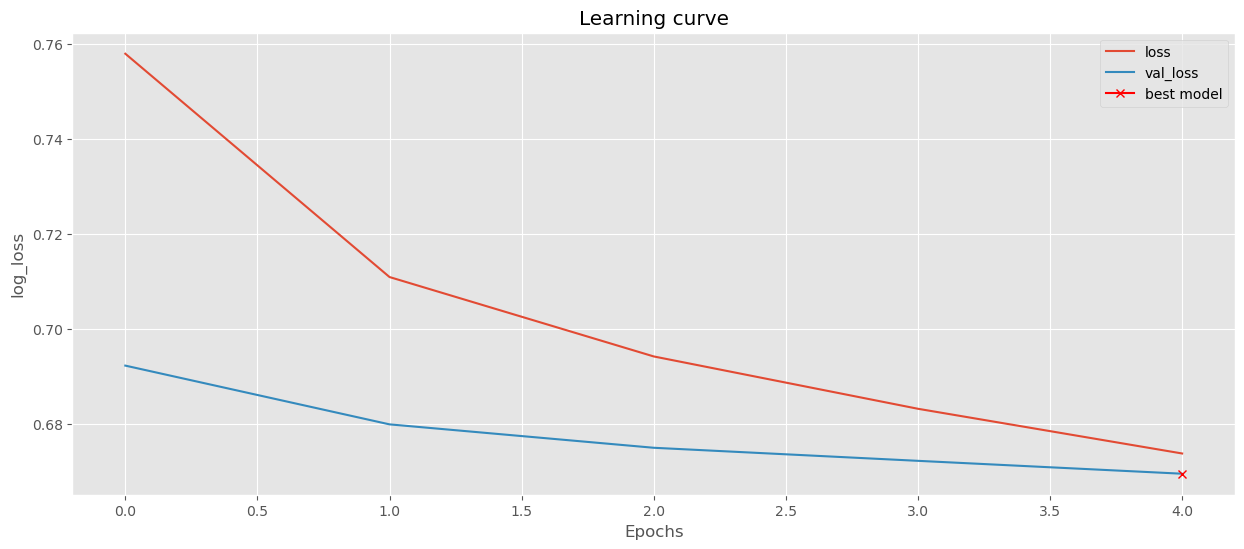

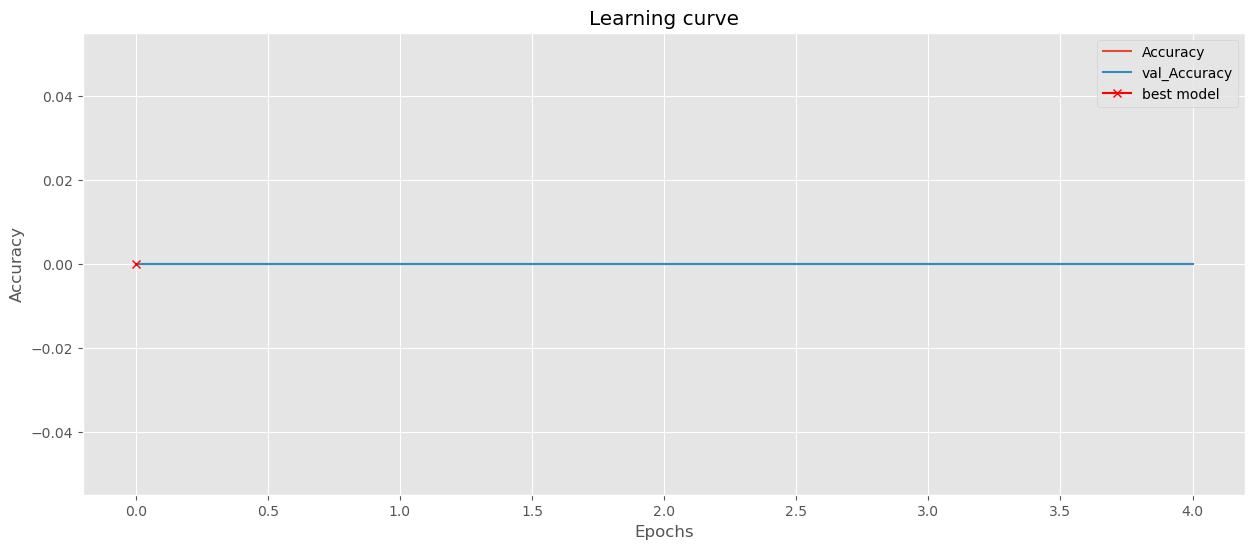

In [99]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Вывод**

In [100]:
model.load_weights('model-DenseUnet.h5')

In [101]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 459ms/step - loss: 0.6695 - accuracy: 0.0000e+00 - auc: 0.0000e+00 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00


[0.6695310473442078, 0.0, 0.0, 0.0, 0.0]

In [102]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 464ms/step


In [103]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [123]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');
    ax[3].set_axis_off()    

# **Прогнозы по тренировочному набору**

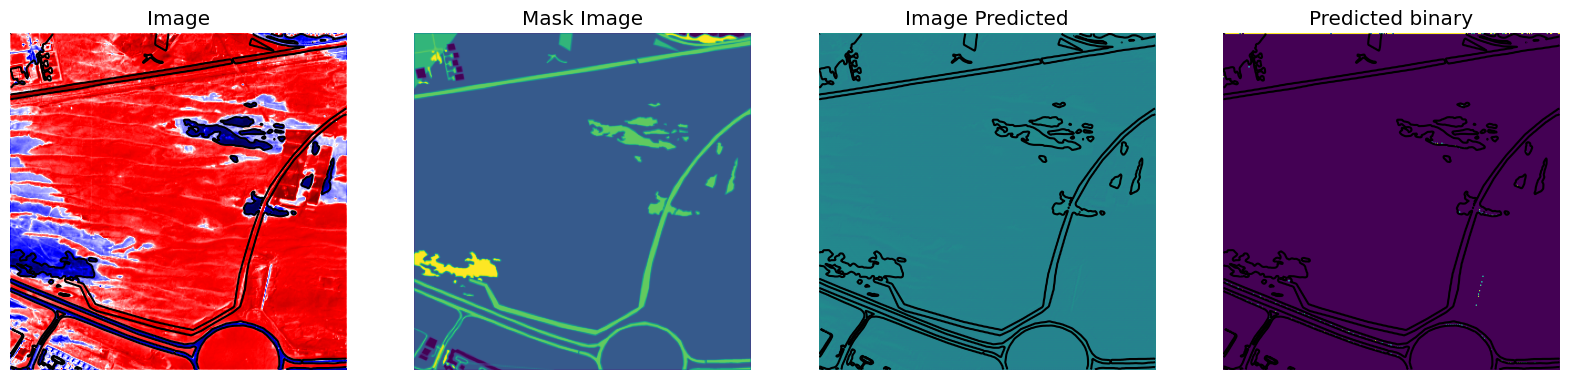

In [124]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=7)

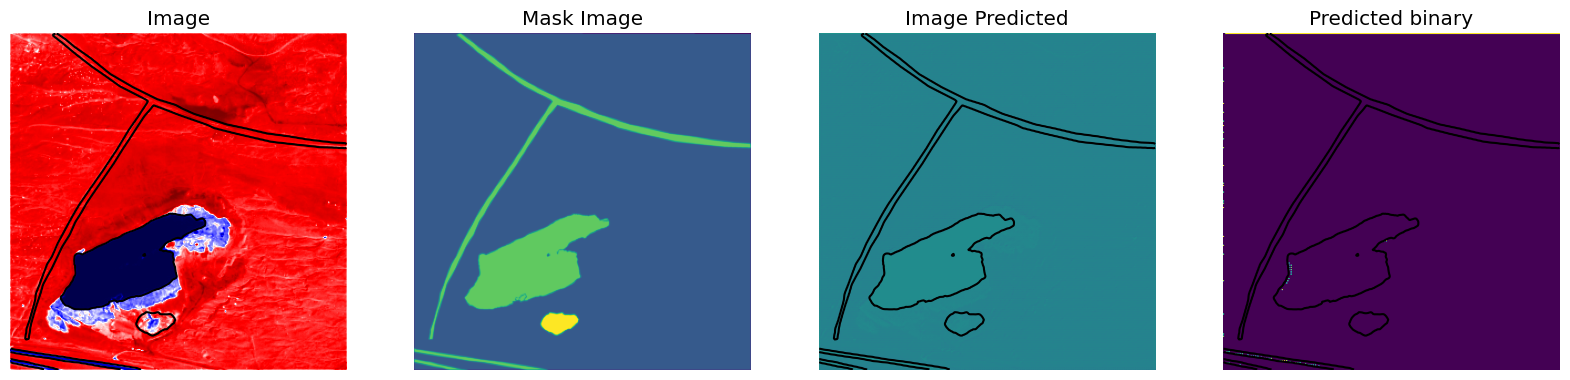

In [125]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

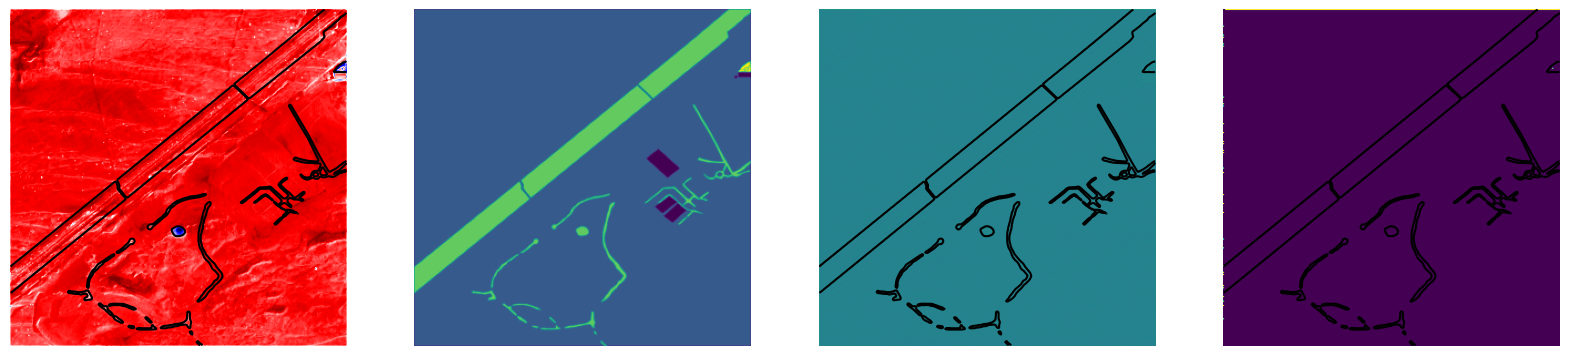

In [117]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

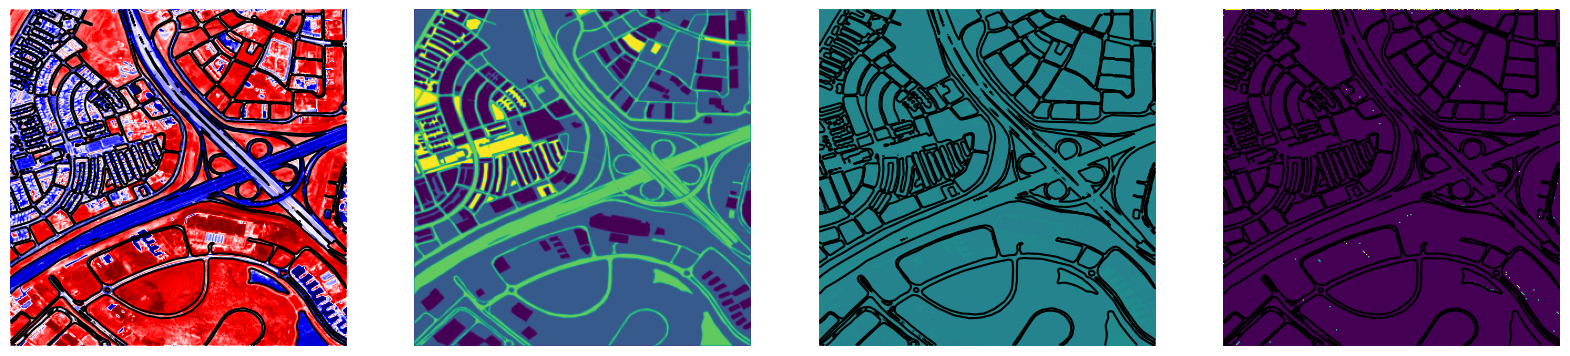

In [118]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

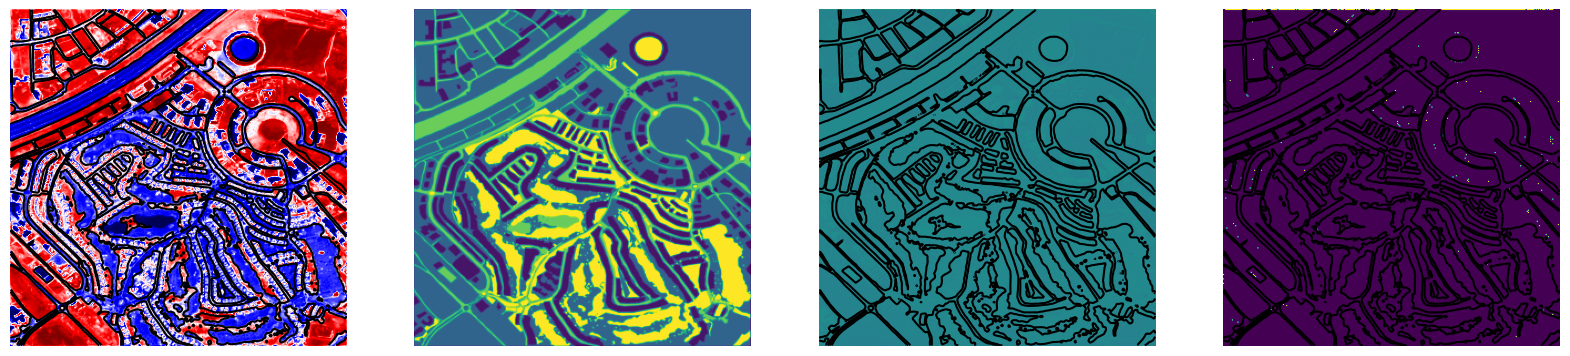

In [120]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

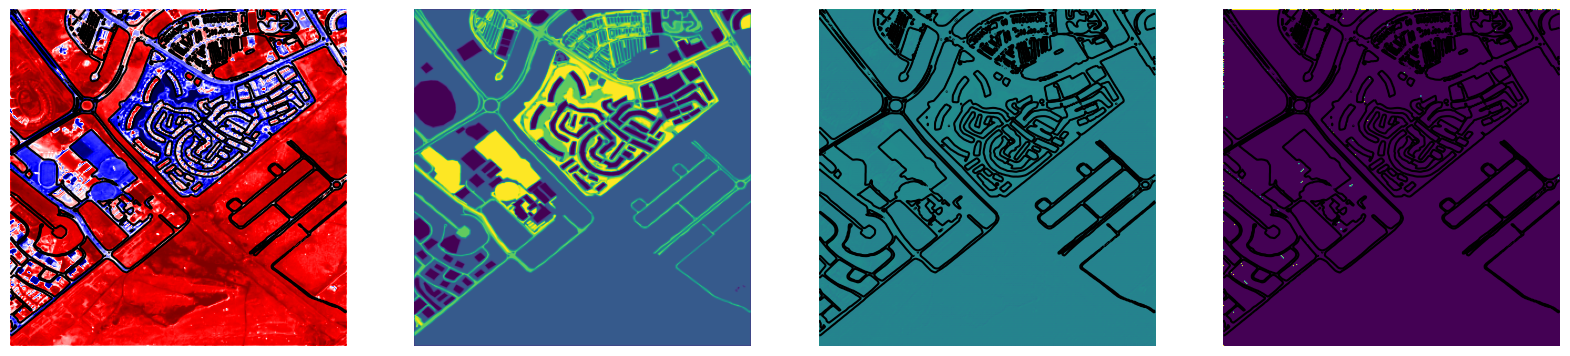

In [121]:
plot_sample(X_train, y_train, preds_train, preds_train_t)